### Table of Contents

* [Data preparation](#data-preparation)
* [Helper methods](#Helper-methods)
* [Model training](#Model-training)
* [Model evaluation](#Model-evaluation)
* [Feature importance](#Feature-importance)
* [Notes](#Notes)


### Data preparation

In [1]:
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularPredictor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

warnings.simplefilter('ignore')

In [15]:
df = pd.read_csv('../data/df-merged-v2.csv')
df.head(3)

,bst_nr_8,country,prod_date,num_trips,delay_minutes,dayofweek,weekofyear,month,latitude,longitude,...,prcp,snow,wdir,wspd,wpgt,pres,tsun,bundesland,regierungsbezirk,landkreis
0,80197079,DEUTSCHLAND,2016-03-16,39,49,3,11,3,49.42045,7.613668,...,0.0,0.0,49.5,21.2,NaN,1024.5,NaN,Rheinland-Pfalz,Rheinhessen-Pfalz,Kaiserslautern
1,80197079,DEUTSCHLAND,2016-10-11,38,74,2,41,10,49.42045,7.613668,...,0.0,0.0,NaN,3.4,NaN,NaN,NaN,Rheinland-Pfalz,Rheinhessen-Pfalz,Kaiserslautern
2,80197079,DEUTSCHLAND,2016-08-29,27,33,1,35,8,49.42045,7.613668,...,0.0,0.0,NaN,6.9,NaN,1018.8,NaN,Rheinland-Pfalz,Rheinhessen-Pfalz,Kaiserslautern


In [17]:
# excluded_columns = ['bst_nr_8', 'prod_date', 'country', 'day', 'bundesland', 'regierungsbezirk']
# df = df[df.columns.difference(excluded_columns)]

columns = ['landkreis', 'latitude', 'longitude', 'num_trips', 'delay_minutes']
df = df[columns]
df.columns

Index(['landkreis', 'latitude', 'longitude', 'num_trips', 'delay_minutes'], dtype='object')

In [48]:
intervals = [(0, 20), (20, 40), (40, 60), (60, 90), (90, 120), (120, 160), (160, 240), (240, 999)]

for (a,b) in intervals:
    print('[%s, %s]' %(a,b), ':\t' ,len(df[(df['num_trips'] >= a) & (df['num_trips'] < b)]))

[0, 20] :	 224369
[20, 40] :	 256828
[40, 60] :	 106630
[60, 90] :	 70439
[90, 120] :	 26866
[120, 160] :	 10054
[160, 240] :	 2715
[240, 999] :	 267


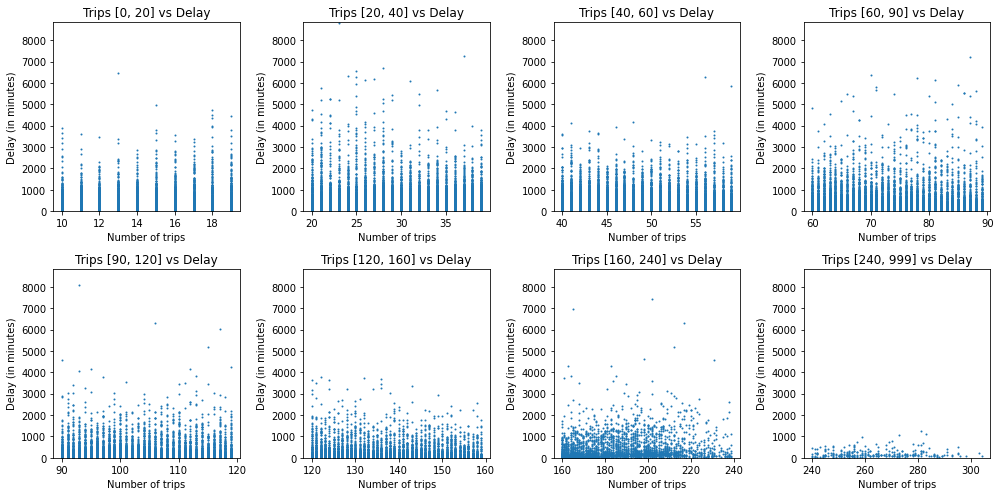

In [49]:
fig, axs = plt.subplots(2, 4, figsize=(14, 7), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

intervals = [(0, 20), (20, 40), (40, 60), (60, 90), (90, 120), (120, 160), (160, 240), (240, 999)]
axs = axs.ravel()
targets = zip(intervals, axs.flatten())

delay_max = df['delay_minutes'].max() + 10

for k, (intr, ax) in enumerate(targets):
    dfx = df[(df['num_trips'] >= intr[0]) & (df['num_trips'] < intr[1])][['num_trips', 'delay_minutes']]
    
    ax.scatter(dfx['num_trips'], dfx['delay_minutes'], s=1)
    ax.set_title('Trips [%s, %s] vs Delay' % intr)
    ax.set_xlabel('Number of trips')
    ax.set_ylabel('Delay (in minutes)')
    ax.set_ylim([0, delay_max])

fig.tight_layout()
plt.show()

### Helper methods

In [11]:
def create_train_test_dataset(dataset, target_column, test_size=0.2):
    """
    Creates train and test datasets
    
    :param dataset: Pandas DataFrame
    :param target_column: str
    :param test_size:
    :return: X_train, X_test, y_train, y_test
    """
    feature_names = dataset.columns.difference([TARGET])
    X = dataset[feature_names]
    y = dataset[[TARGET]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    return X_train, X_test, y_train, y_test


def run_autogluon_experiment(dataset,
                             target_column,
                             problem_type,
                             eval_metric,
                             time_limit=600):
    """
    Fits training dataset on autogluon.TabularPredictor

    :param dataset:
    :param target_column:
    :param problem_type:
    :param eval_metric:
    :param time_limit:
    :return:
    """
    predictor = TabularPredictor(
        label = target_column,
        problem_type = problem_type,
        eval_metric = eval_metric,
        # learner_kwargs = {'ignored_columns': ['BST_NR_8', 'Land', 'PROD_DATUM', 'dayofweek']}
    )
    
    # hyperparameters={'RF':{}, 'GBM':{}, 'XT':{}, 'XGB':{}}
    hyperparameters={'GBM':{}, 'XGB':{}}
    
    predictor.fit(
        train_data = dataset,
        time_limit = time_limit,
        hyperparameters = hyperparameters, 
        presets='high_quality_fast_inference_only_refit',
    )
    
    return predictor

### Model training

In [ ]:
TEST_SIZE = 0.2
TIME_LIMIT = 600

TARGET = 'delay_minutes'
PROBLEM_TYPE = 'regression'
EVAL_METRIC = 'root_mean_squared_error'

intervals = [(0, 20), (20, 40), (40, 60), (60, 90), (90, 120), (120, 160), (160, 240), (240, 999)]
a, b = intervals[0]

dfx = df[(df['num_trips'] >= a) & (df['num_trips'] < b)]

X_train, X_test, y_train, y_test = create_train_test_dataset(
    dataset = dfx, 
    target_column = TARGET,
    test_size=TEST_SIZE
)

train_data = pd.concat([X_train, y_train], axis=1)
     
predictor = run_autogluon_experiment(dataset=train_data,
                                     target_column=TARGET,
                                     problem_type=PROBLEM_TYPE,
                                     eval_metric=EVAL_METRIC,
                                     time_limit=TIME_LIMIT)

### Model evaluation

In [27]:
test_data = pd.concat([X_test, y_test], axis=1)
test_performance = predictor.evaluate(test_data, auxiliary_metrics=False)

Evaluation: root_mean_squared_error on test data: -168.86581873505983
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -168.86581873505983
}


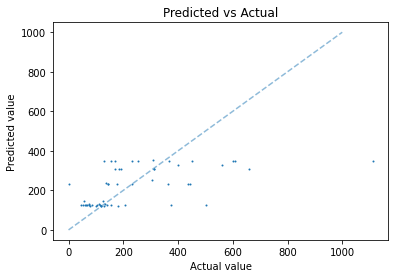

In [50]:
predictions = predictor.predict(test_data)

plt.scatter(test_data['delay_minutes'], predictions, s=1)

ident = [0.0, 1000.0]
plt.plot(ident,ident, '--', alpha=0.5)

plt.title('Predicted vs Actual')
plt.xlabel('Actual value')
plt.ylabel('Predicted value')
plt.show()

### Feature importance

In [ ]:
# feature importance on training dataset

predictor.feature_importance(data=train_data)

In [106]:
# feature importance on test dataset 

predictor.feature_importance(data=test_data)

Computing feature importance via permutation shuffling for 17 features using 1000 rows with 3 shuffle sets...
	17.71s	= Expected runtime (5.9s per shuffle set)
	3.77s	= Actual runtime (Completed 3 of 3 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
landkreis,36.275015,15.967443,0.029467,3,127.770231,-55.220202
latitude,29.096898,4.351321,0.003686,3,54.030451,4.163346
longitude,28.993663,12.090725,0.026684,3,98.274856,-40.287529
num_trips,7.522745,4.675300,0.054122,3,34.312732,-19.267242
weekofyear,6.119991,9.348061,0.187221,3,59.685415,-47.445434
wpgt,2.229005,1.674769,0.073808,3,11.825619,-7.367609
tsun,1.791223,2.294953,0.154502,3,14.941556,-11.359109
wdir,1.285769,0.941807,0.070889,3,6.682429,-4.110892
dayofweek,1.209577,1.861880,0.188689,3,11.878357,-9.459203
pres,0.926111,1.183722,0.154071,3,7.708970,-5.856749


### Notes

---------------------------------

Time limit: 10 Minutes

Dataset: db-cargo-delays-2016-deutschland.csv

Features: Zugfahrten, Verspaetungsminuten, weekofyear

RMSE: 177.84

Updated on: 06.01.2022 

---------------------------------

Time limit: 10 Minutes

Dataset: df-merged-v2.csv

Features: ['bst_nr_8', 'day', 'dayofweek', 'delay_minutes', 'latitude', 'longitude', 
            'month', 'num_trips', 'prcp', 'pres', 'snow', 'tavg', 'tmax', 'tmin', 'tsun', 
            'wdir', 'weekofyear', 'wpgt', 'wspd']

Presets: 'high_quality_fast_inference_only_refit',

RMSE: 134.25

Updated on: 08.01.2022 

---------------------------------

Time limit: 10 Minutes

Dataset: df-merged-v2.csv

Month: 1

Features: ['bst_nr_8', 'day', 'dayofweek', 'delay_minutes', 'latitude', 'longitude', 
            'month', 'num_trips', 'prcp', 'pres', 'snow', 'tavg', 'tmax', 'tmin', 'tsun', 
            'wdir', 'weekofyear', 'wpgt', 'wspd']

Presets: 'high_quality_fast_inference_only_refit',

RMSE: 147.47

Updated on: 08.01.2022 

---------------------------------

Time limit: 10 Minutes

Dataset: df-merged-v2.csv

Month: 1

Features: ['dayofweek', 'delay_minutes', 'landkreis', 'latitude', 'longitude', 
       'num_trips', 'prcp', 'pres', 'snow', 'tavg', 'tmax', 'tmin', 'tsun',
       'wdir', 'weekofyear', 'wpgt', 'wspd']

Presets: 'high_quality_fast_inference_only_refit',

RMSE: 136.79

Updated on: 09.01.2022 

---------------------------------